In [1]:
import zipfile

with zipfile.ZipFile("nlp_news_classifier.zip", "r") as zip_ref:
    zip_ref.extractall(".")

- Importar bibliotecas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from bertopic import BERTopic
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

- Upload do dataset

In [3]:
df = pd.read_csv("/content/nlp_news_classifier/data/bbc_news.csv")
df

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...
...,...,...,...,...,...
42110,Highlights: Wales make history in Dublin,"Tue, 03 Dec 2024 23:07:27 GMT",https://www.bbc.com/sport/football/videos/ckg1...,https://www.bbc.com/sport/football/videos/ckg1...,Watch highlights as Wales win 2-1 in Dublin fo...
42111,Gang jailed over £200m of cocaine in banana boxes,"Tue, 03 Dec 2024 17:48:54 GMT",https://www.bbc.com/news/articles/c3e8pvg284no#9,https://www.bbc.com/news/articles/c3e8pvg284no,More than two tonnes of the Class A drug was s...
42112,Scottish Budget presents huge challenges for SNP,"Tue, 03 Dec 2024 23:00:17 GMT",https://www.bbc.com/news/articles/ckg1m1j2grpo#9,https://www.bbc.com/news/articles/ckg1m1j2grpo,Finance Secretary Shona Robison is preparing t...
42113,Celebrations as Wales make history qualifying ...,"Wed, 04 Dec 2024 00:05:52 GMT",https://www.bbc.com/news/articles/c791nq8nl73o#9,https://www.bbc.com/news/articles/c791nq8nl73o,Wales defeated the Republic of Ireland 2-1 mak...


- Colunas do dataset

In [4]:
df.columns

Index(['title', 'pubDate', 'guid', 'link', 'description'], dtype='object')

- Distrubuição das variáveis

title : 39653
pubDate : 40189
guid : 39203
link : 37856
description : 38731


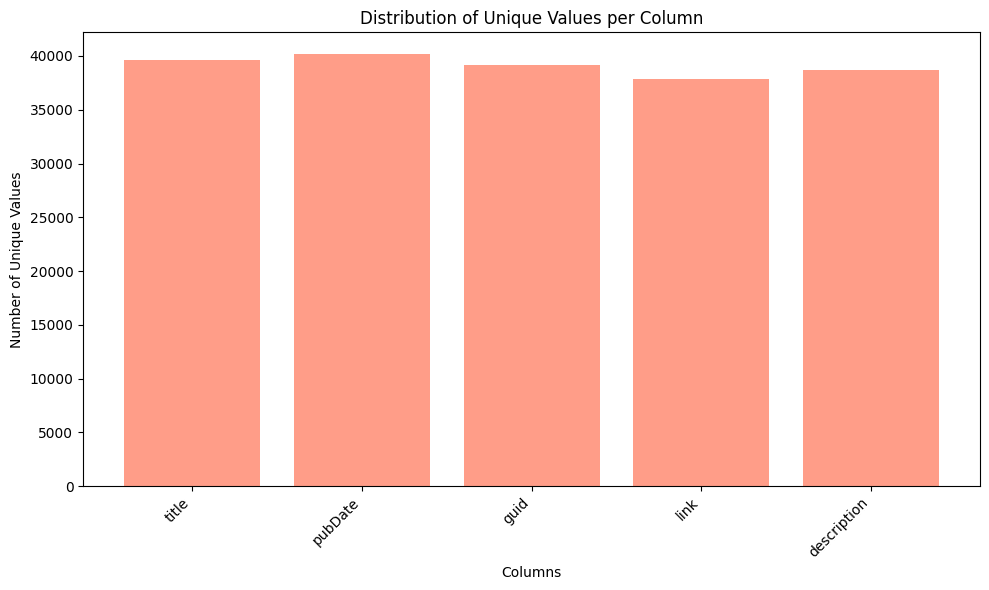

In [5]:
for col in df:
    print(col,":",len(df[col].unique()))


unique_counts = {}
columns_to_plot = ["title", "pubDate", "guid", "link", "description"]

for col in columns_to_plot:
    if col in df.columns:
        unique_counts[col] = len(df[col].unique())
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

plot_columns = list(unique_counts.keys())
plot_values = list(unique_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(plot_columns, plot_values, color='#ff9d88')
plt.title('Distribution of Unique Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Estatísticas básicas

In [6]:
print(f"Total of documents: {len(df['title'])}")
print(f"Empty texts: {df['description'].str.strip().eq('').sum()}")
print(f"Null texts: {df['description'].isnull().sum()}")

Total of documents: 42115
Empty texts: 0
Null texts: 0


- Eliminar nulos

In [7]:
df['description'] = df['description'].fillna("")

In [8]:
!pip install -U spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 117.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
import spacy

# Carrega o modelo
nlp = spacy.load("en_core_web_sm")

# Limpa NaNs
df['description'] = df['description'].fillna("")

# Lista de textos
texts = df['description'].tolist()

# Processa em batches de 100 (podes aumentar para 500 se tiveres boa memória)
sentence_counts = [len(list(doc.sents)) for doc in nlp.pipe(texts, batch_size=100)]

# Adiciona ao DataFrame
df['sentence_count'] = sentence_counts

# As outras métricas são rápidas
df['text_length'] = df['description'].str.len()
df['word_count'] = df['description'].str.split().str.len()


In [10]:
# Prints (se quiseres)
print("Carateres por texto:")
print(f"  Mean: {df['text_length'].mean():.2f}")
print(f"  Median: {df['text_length'].median():.2f}")
print(f"  Min: {df['text_length'].min()}")
print(f"  Max: {df['text_length'].max()}")

print(f"\nNúmero de palavras por texto:")
print(f"  Mean: {df['word_count'].mean():.2f}")
print(f"  Median: {df['word_count'].median():.2f}")
print(f"  Min: {df['word_count'].min()}")
print(f"  Max: {df['word_count'].max()}")

print(f"\nNúmero de frases por texto:")
print(f"  Mean: {df['sentence_count'].mean():.2f}")
print(f"  Median: {df['sentence_count'].median():.2f}")
print(f"  Min: {df['sentence_count'].min()}")
print(f"  Max: {df['sentence_count'].max()}")


Carateres por texto:
  Mean: 104.33
  Median: 99.00
  Min: 22
  Max: 258

Número de palavras por texto:
  Mean: 17.55
  Median: 17.00
  Min: 4
  Max: 45

Número de frases por texto:
  Mean: 1.03
  Median: 1.00
  Min: 1
  Max: 5


In [11]:
print(df['description'].head(10).tolist())

['The Ukrainian president says the country will not forgive or forget those who murder its civilians.', 'Jeremy Bowen was on the frontline in Irpin, as residents came under Russian fire while trying to flee.', "One of the world's biggest fertiliser firms says the conflict could deliver a shock to food supplies.", "The parents of the Manchester Arena bombing's youngest victim speak about their life since she died.", 'Consumers are feeling the impact of higher energy costs as fuel prices and household bills jump.', 'Boris Johnson is to meet the Canadian and Dutch PMs, as MPs debate new laws targeting oligarchs.', 'The home secretary says she is "surging capacity" as about 1% of 5,500 applications are granted.', 'TikTok suspends live streaming and new content from its platform, while Russians can no longer access Netflix.', 'Five things you need to know about the coronavirus pandemic this Monday morning.', 'People have been held in 53 cities, from St Petersburg in the west to Vladivostok 

- Converter pubDate para Datetime

In [12]:
df['pubDate'] = pd.to_datetime(df['pubDate'],
                               format='%a, %d %b %Y %H:%M:%S %Z',
                               errors='coerce')

print(df['pubDate'])

0       2022-03-07 08:01:56+00:00
1       2022-03-06 22:49:58+00:00
2       2022-03-07 00:14:42+00:00
3       2022-03-07 00:05:40+00:00
4       2022-03-07 08:15:53+00:00
                   ...           
42110   2024-12-03 23:07:27+00:00
42111   2024-12-03 17:48:54+00:00
42112   2024-12-03 23:00:17+00:00
42113   2024-12-04 00:05:52+00:00
42114   2024-12-04 00:03:58+00:00
Name: pubDate, Length: 42115, dtype: datetime64[ns, UTC]


- Eliminar duplicados

In [13]:
df = df.drop_duplicates(subset=['guid'])
print(f'{len(df):,} linhas após remover duplicados')

39,203 linhas após remover duplicados


- Limpeza dos dados

- Remover espaços extra

In [14]:
df['description'] = df['description'].str.strip().str.replace('\s+', ' ', regex=True)

<ipython-input-14-83dea8d5e743>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description'] = df['description'].str.strip().str.replace('\s+', ' ', regex=True)


- Converter para minúsculas

In [15]:
df['description'] = df['description'].str.strip().str.replace('\s+', ' ', regex=True)

<ipython-input-15-83dea8d5e743>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description'] = df['description'].str.strip().str.replace('\s+', ' ', regex=True)


- Remover carateres especiais, pontuação e emojis

In [16]:
import re

def clean_special(text):
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove pontuação
    text = re.sub(r'\d+', '', text)       # Remove números
    text = re.sub(r'[\u2600-\u26FF\u2700-\u27BF]', '', text)  # Remove alguns emojis comuns
    text = re.sub(r'\s+', ' ', text)      # Remove espaços a mais
    return text.strip()

df['description'] = df['description'].apply(clean_special)


<ipython-input-16-c0a110fc0ced>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description'] = df['description'].apply(clean_special)


- Remover stopwords

In [17]:
def remove_stopwords(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if not token.is_stop])

df['description'] = df['description'].apply(remove_stopwords)

<ipython-input-17-f1d90b783355>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description'] = df['description'].apply(remove_stopwords)


- Lematização

In [18]:
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

df['description'] = df['description'].apply(lemmatize_text)

<ipython-input-18-e26e0919c513>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description'] = df['description'].apply(lemmatize_text)


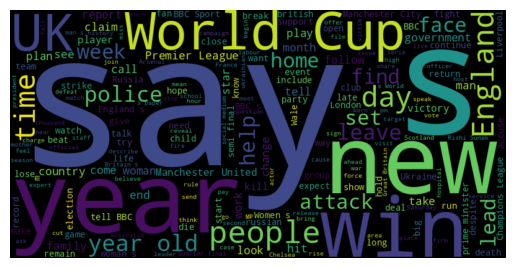

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=800, height=400).generate(' '.join(df['description']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


- Classificação semântica com embeddings

In [24]:
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer, util
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')

category_names = ["Sports", "Politics", "Health", "World", "Weather","War","Tourism","Market"]
category_embeddings = model.encode(category_names)

def semantic_category(text):
    text_emb = model.encode([text])[0]
    similarities = util.cos_sim(text_emb, category_embeddings)[0].numpy()
    best_idx = np.argmax(similarities)
    return category_names[best_idx]

df['predicted_category'] = df['description'].apply(semantic_category)


- Ver como são as previsões

In [25]:
print(df['predicted_category'].value_counts())

for cat in df['predicted_category'].unique():
    print(f"\nCategoria: {cat}")
    print(df[df['predicted_category'] == cat]['description'].head(3).tolist())


predicted_category
Sports      6821
Politics    5934
Tourism     4906
Market      4879
War         4725
Health      4666
World       4037
Weather     3235
Name: count, dtype: int64

Categoria: War
['ukrainian president say country forgive forget murder civilian', 'world s big fertiliser firm say conflict deliver shock food supply', 'parent Manchester Arena bombing s young victim speak life die']

Categoria: World
['Jeremy Bowen frontline Irpin resident come russian fire try flee', 'Russia seize nuclear plant site expert weigh risk Ukraine world large', 'key map chart explain virus spread world']

Categoria: Market
['consumer feel impact high energy cost fuel price household bill jump', 'home secretary say surging capacity application grant', 'price everyday item time cost live rise']

Categoria: Politics
['Boris Johnson meet canadian dutch pms mps debate new law target oligarch', 'Ukraine s young cabinet minister year old Mykhailo Fedorov lead cyber battle Russia', 'president fail meas

- Visualizar resultados

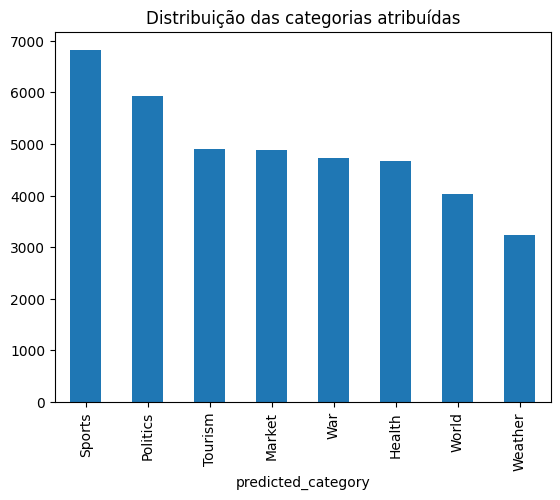

In [26]:
df['predicted_category'].value_counts().plot(kind='bar')
plt.title("Distribuição das categorias atribuídas")
plt.show()

- Ver exemplos de categorias

In [31]:
for cat in df['predicted_category'].unique():
    print(f"\nExemplos da categoria '{cat}':")
    print(df[df['predicted_category'] == cat]['description'].sample(2).tolist())


Exemplos da categoria 'War':
['world champion Hannah Rankin respond September title defeat dominant victory Logan Holler', 'largely unpredictable unforeseeable twister threat']

Exemplos da categoria 'World':
['Saudi Arabia set host man s World Cup Fifa confirm bidder tournament', 'Belgium fear lose haven t good Belgium say boss Roberto Martinez World Cup defeat Morocco']

Exemplos da categoria 'Market':
['Alan Browne come bench score late equaliser earn Republic Ireland creditable friendly draw Belgium Dublin', 'property Jurassic Coast ft m ft m drop edge']

Exemplos da categoria 'Politics':
['Commons leader Lucy Powell say measure remain labour commitment current parliament', 'pre election tax cut Holly Willoughby s return Morning feature Sunday s paper']

Exemplos da categoria 'Sports':
['Argentina win World Cup Qatar know Lionel Messi s World Cup say BBC Sport s Phil McNulty', 'Craig Gibson appear court allege assault Toronto']

Exemplos da categoria 'Health':
['favourite treat go

- Extrair entidades por categoria

In [34]:
from collections import Counter

def extract_entities(text):
    doc = nlp(text)
    people = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    places = [ent.text for ent in doc.ents if ent.label_ in ["GPE", "LOC"]]
    orgs = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    return people, places, orgs

df[['people', 'places', 'organizations']] = df['description'].apply(
    lambda x: pd.Series(extract_entities(x))
)

for cat in df['predicted_category'].unique():
    print(f"\nCategoria: {cat}")

    people = sum(df[df['predicted_category'] == cat]['people'], [])
    places = sum(df[df['predicted_category'] == cat]['places'], [])
    orgs = sum(df[df['predicted_category'] == cat]['organizations'], [])

    print("Pessoas mais citadas:", Counter(people).most_common(5))
    print("Locais mais citados:", Counter(places).most_common(5))
    print("Organizações mais citadas:", Counter(orgs).most_common(5))


Categoria: War
Pessoas mais citadas: [('Putin', 38), ('Vladimir Putin', 26), ('Jeremy Bowen', 19), ('Zelensky', 17), ('Kyiv', 17)]
Locais mais citados: [('Ukraine', 489), ('Russia', 367), ('Israel', 319), ('Gaza', 228), ('UK', 184)]
Organizações mais citadas: [('BBC', 207), ('Hamas', 157), ('UN', 41), ('Hezbollah', 31), ('Tyson Fury', 23)]

Categoria: World
Pessoas mais citadas: [('Max Verstappen', 30), ('Ronnie', 21), ('Sullivan', 18), ('Gareth Southgate', 17), ('Euro', 17)]
Locais mais citados: [('England', 276), ('UK', 142), ('London', 74), ('France', 67), ('Australia', 59)]
Organizações mais citadas: [('BBC', 225), ('Wales', 16), ('Euro', 16), ('Women s World Cup', 15), ('Amazon', 12)]

Categoria: Market
Pessoas mais citadas: [('Manchester United', 69), ('Rishi Sunak', 44), ('Keir Starmer', 28), ('Jim Ratcliffe', 14), ('Jurgen Klopp', 12)]
Locais mais citados: [('UK', 230), ('England', 66), ('Manchester City', 47), ('Russia', 37), ('London', 35)]
Organizações mais citadas: [('BBC'

- Clustering dentro de cada categoria

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

n_clusters = 3

for cat in df['predicted_category'].unique():
    cat_df = df[df['predicted_category'] == cat]
    texts = cat_df['description'].tolist()

    if len(texts) < n_clusters:
        print(f"\nCategoria '{cat}': poucos textos, impossível clusterizar.")
        continue

    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(texts)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)

    cat_df = cat_df.copy()
    cat_df['subcluster'] = clusters

    print(f"\nCategoria '{cat}' — Sub-temas encontrados:")
    for i in range(n_clusters):
        print(f"\nSub-tema {i+1}:")
        print(cat_df[cat_df['subcluster'] == i]['description'].head(3).tolist())



Categoria 'War' — Sub-temas encontrados:

Sub-tema 1:
['parent Manchester Arena bombing s young victim speak life die', 'hour Russia s invasion Ukraine volunteer offer service', 'ceasefire agreement southern city Mariupol break second time side blame']

Sub-tema 2:
['ukrainian president say country forgive forget murder civilian', 'world s big fertiliser firm say conflict deliver shock food supply', 'false claim chemical weapon development russian ploy justify attack say Jen Psaki']

Sub-tema 3:
['million Ukrainians flee country s need know day war', 'russian gymnast Ivan Kuliak investigate wear national war symbol leotard stand ukrainian rival podium Qatar Saturday', 'conspiracy theory troll add chaos war']

Categoria 'World' — Sub-temas encontrados:

Sub-tema 1:
['Jeremy Bowen frontline Irpin resident come russian fire try flee', 'Russia seize nuclear plant site expert weigh risk Ukraine world large', 'key map chart explain virus spread world']

Sub-tema 2:
['year old write Disney y

- Divisão em treino e teste

In [36]:
from sklearn.model_selection import train_test_split

X = df['description']
y = df['predicted_category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

- Vetorização TF-IDF

In [37]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

- Modelo

In [38]:
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=42)

- Avaliação dos resultados

Accuracy: 0.6598648131615865
              precision    recall  f1-score   support

      Health       0.65      0.65      0.65       933
      Market       0.65      0.63      0.64       976
    Politics       0.70      0.79      0.74      1187
      Sports       0.71      0.80      0.75      1364
     Tourism       0.60      0.64      0.62       981
         War       0.72      0.64      0.67       945
     Weather       0.64      0.50      0.56       647
       World       0.55      0.47      0.51       808

    accuracy                           0.66      7841
   macro avg       0.65      0.64      0.64      7841
weighted avg       0.66      0.66      0.66      7841



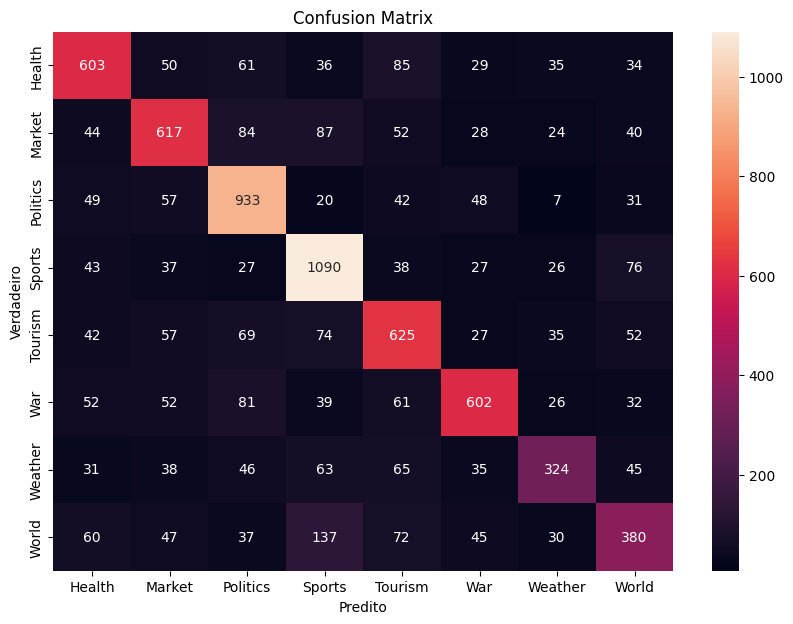

In [39]:
y_pred = clf.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True,
            fmt='d',
            xticklabels=clf.classes_,
            yticklabels=clf.classes_)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Confusion Matrix')
plt.show()


In [40]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

MultinomialNB()

Accuracy: 0.6078306338477235
              precision    recall  f1-score   support

      Health       0.57      0.62      0.59       933
      Market       0.65      0.55      0.59       976
    Politics       0.61      0.78      0.69      1187
      Sports       0.64      0.81      0.71      1364
     Tourism       0.54      0.60      0.57       981
         War       0.62      0.62      0.62       945
     Weather       0.67      0.36      0.47       647
       World       0.55      0.26      0.35       808

    accuracy                           0.61      7841
   macro avg       0.61      0.58      0.58      7841
weighted avg       0.61      0.61      0.59      7841



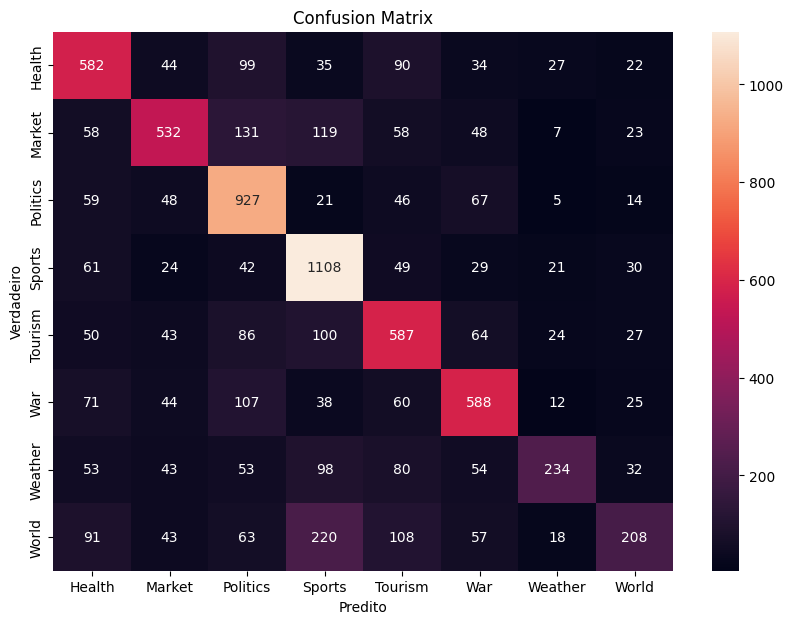

In [41]:
y_pred = clf.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True,
            fmt='d',
            xticklabels=clf.classes_,
            yticklabels=clf.classes_)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Confusion Matrix')
plt.show()
